# Advanced Optimization of the Model

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import phoebe
logger = phoebe.logger('WARNING')
%matplotlib inline
phoebe.multiprocessing_on()

Import the PHOEBE bundle that we made in the last notebook:

In [2]:
b = phoebe.open('bundles/after_nm_fast.bundle')

# Update Physics

Now we will set a new set of compute options to compute models with more detailed physics

In [3]:
b.add_compute(compute='comp_phys')

<ParameterSet: 46 parameters | datasets: lc01, rv01, _default>

Now we add the fitting options to make the computations more detailed. 

In [4]:
b.set_value_all('ld_mode', value='interp')
b.set_value_all('atm', value='ck2004')
b.set_value('irrad_method', compute='comp_phys', value='horvat')
b.set_value_all('rv_method', compute='comp_phys', value='flux-weighted')
b.set_value_all('distortion_method', compute='comp_phys', value='roche')

Increase the number of triangles that cover the stellar surfaces (this provides higher resolution):

In [5]:
b['ntriangles@secondary@comp_phys']=2000

## Fitting with the Nelder Mead optimizer

Add a new solver with a new name (nm_phys) and tell it to use the new compute settings with more detailed physics: 

In [6]:
b.add_solver('optimizer.nelder_mead',  solver='nm_phys', compute='comp_phys', overwrite=True)

<ParameterSet: 14 parameters | qualifiers: use_server, priors, expose_lnprobabilities, initial_values, fatol, progress_every_niters, fit_parameters, comments, maxiter, compute, continue_from, xatol, priors_combine, adaptive>

Update the maximum number of iterations:

In [7]:
b.set_value('maxiter', solver='nm_phys', value=100)

## Fit the light curve only with Nelder Mead optimizer

Since we're already quite close, we can first fit the light curve data. To do this, we will disable the radial velocity curve:

In [8]:
b.disable_dataset('rv01')

<ParameterSet: 20 parameters | components: binary, secondary, primary>

Select the parameters to be fitted:

In [9]:
fit_params = ['teffratio@binary', 'requivratio', 'requivsumfrac@binary']
b.set_value('fit_parameters@nm_phys', fit_params)

Run the solver:

In [10]:
b.run_solver(solver='nm_phys', compute='comp_phys', solution='nm_lc_sol_phys', overwrite=True)

100%|███████████████████████████████████████| 100/100 [1:14:02<00:00, 44.42s/it]


<ParameterSet: 11 parameters | qualifiers: fitted_twigs, initial_values, fitted_values, adopt_values, niter, adopt_distributions, message, comments, success, adopt_parameters, fitted_units>

First take a look at the parameters without adopting them using "trial run":

In [11]:
print(b.adopt_solution('nm_lc_sol_phys', trial_run=True))

ParameterSet: 3 parameters
   teffratio@binary@orbit@comp...: 0.8816045727652025
   requivratio@binary@orbit@co...: 10.233272865150933
   requivsumfrac@binary@orbit@...: 0.09738822017570217


Adopt the solution:

In [12]:
b.adopt_solution('nm_lc_sol_phys')

<ParameterSet: 8 parameters | kinds: star, orbit>

Compute the model with the new solution and plot it to see what it looks like:

In [13]:
b.run_compute(compute='comp_phys', solution='nm_lc_sol_phys', model='nm_lc_mod', overwrite=True)

Fri, 15 Mar 2024 13:49 BUNDLE       WARNING applying passed solution (nm_lc_sol_phys) to sample_from
Fri, 15 Mar 2024 13:49 BUNDLE       WARNING defaulting sample_num=1 since adopt_distributions@nm_lc_sol_phys=False
Fri, 15 Mar 2024 13:49 BACKENDS     WARNING only one sample, falling back on sample_mode='all', sample_num=1 instead of sample_mode='1-sigma', sample_num=1
100%|█████████████████████████████████████████████| 1/1 [00:56<00:00, 56.40s/it]


<ParameterSet: 9 parameters | qualifiers: fluxes, flux_scale, samples, sampled_twigs, comments, failed_samples, times, sample_mode, sampled_uniqueids>

Plot the model:

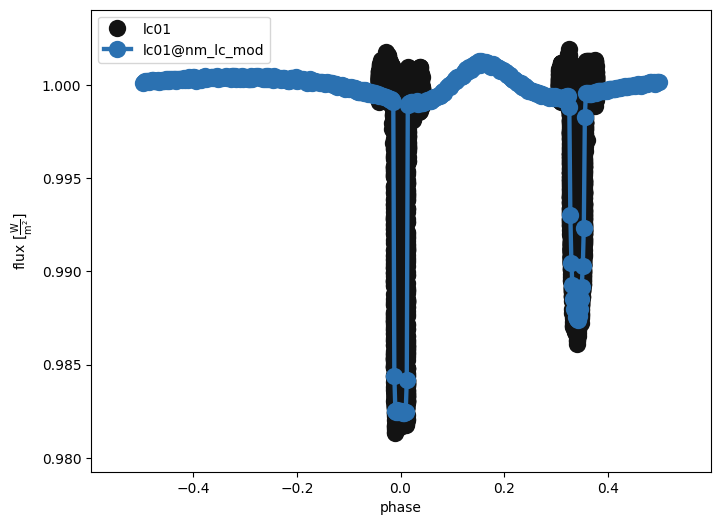

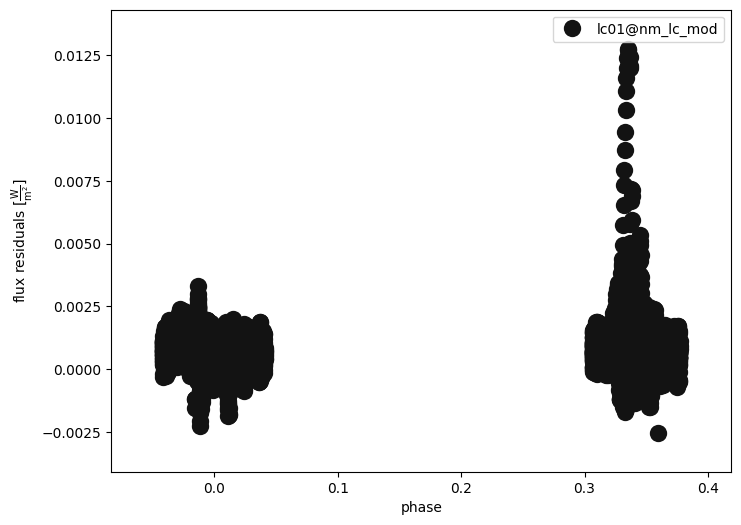

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [14]:
b.plot(kind='lc', model='nm_lc_mod', x='phases', show=True, legend=True, marker = 'o')
b.plot(kind='lc', model='nm_lc_mod', x='phases', y='residuals', show=True, legend=True, marker = 'o')

Now we can fit the eccentricity and argument of periastron and inclination (along with the tempearture ratio). It is important not to fit the radii and inclination together as they are strongly correlated and so could give extreme results)

In [15]:
fit_params = ['teffratio@binary', 'incl@binary','ecc','per0']
b.set_value('fit_parameters@nm_phys', fit_params)

Increase the number of phase points to better sample the light curve:

In [16]:
comp_phases = np.linspace(0,1,1001)
b.set_value('compute_phases', dataset='lc01', value=comp_phases)

Run the solver with the newly selected parameters:

In [17]:
b.run_solver(solver='nm_phys', solution='nm_lc_sol_phys',compute='comp_phys', overwrite=True)

Fri, 15 Mar 2024 13:50 BUNDLE       WARNING fit_parameters contains a parameter (['per0']) that affects phasing which could cause issues with mask_phases
100%|██████████████████████████████████████| 100/100 [2:59:13<00:00, 107.54s/it]


<ParameterSet: 11 parameters | qualifiers: fitted_twigs, initial_values, fitted_values, adopt_values, niter, adopt_distributions, message, comments, success, adopt_parameters, fitted_units>

First take a look at the parameters without adopting them using "trial run":

In [18]:
print(b.adopt_solution(solution='nm_lc_sol_phys', trial_run=True))

ParameterSet: 4 parameters
   teffratio@binary@orbit@comp...: 0.881774546237996
      incl@binary@orbit@component: 90.91157238623374 deg
       ecc@binary@orbit@component: 0.25673704383260204
      per0@binary@orbit@component: 168.66270816446067 deg


Adopt the solution:

In [20]:
b.adopt_solution('nm_lc_sol_phys')

<ParameterSet: 27 parameters | contexts: component, dataset>

Compute the model and plot it:

Fri, 15 Mar 2024 17:15 BUNDLE       WARNING applying passed solution (nm_lc_sol_phys) to sample_from
Fri, 15 Mar 2024 17:15 BUNDLE       WARNING defaulting sample_num=1 since adopt_distributions@nm_lc_sol_phys=False
Fri, 15 Mar 2024 17:15 BACKENDS     WARNING only one sample, falling back on sample_mode='all', sample_num=1 instead of sample_mode='1-sigma', sample_num=1
100%|█████████████████████████████████████████████| 1/1 [01:09<00:00, 69.54s/it]


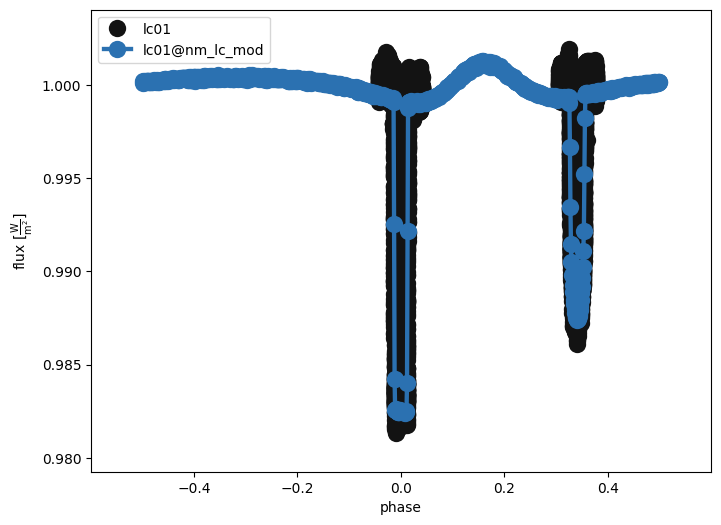

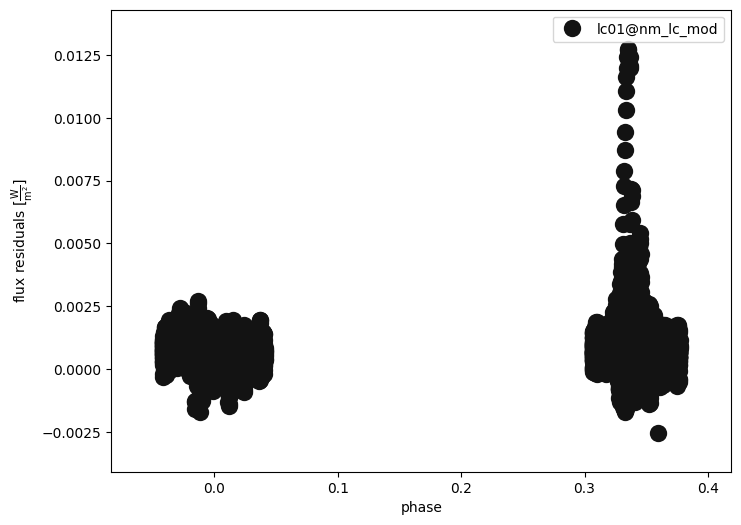

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [21]:
b.run_compute(compute='comp_phys', solution='nm_lc_sol_phys', model='nm_lc_mod', overwrite=True)

b.plot(kind='lc', model='nm_lc_mod', x='phases', show=True, legend=True, marker = 'o')
b.plot(kind='lc', model='nm_lc_mod', x='phases', y='residuals', show=True, legend=True, marker = 'o')

Plot the residuals for each eclipse:

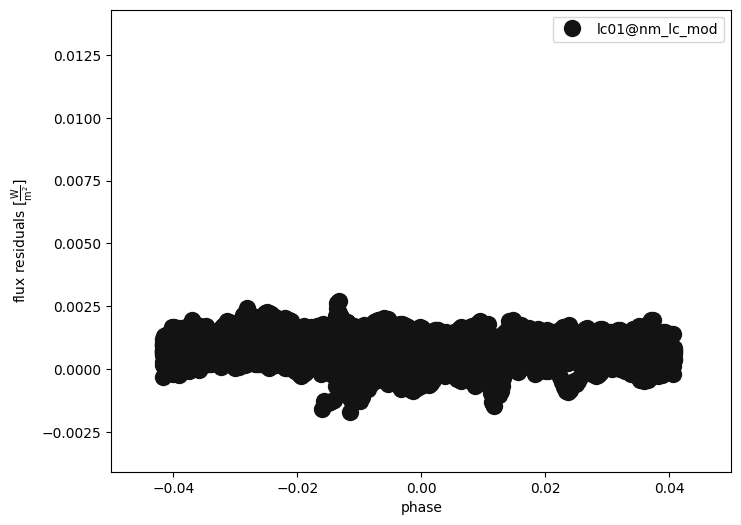

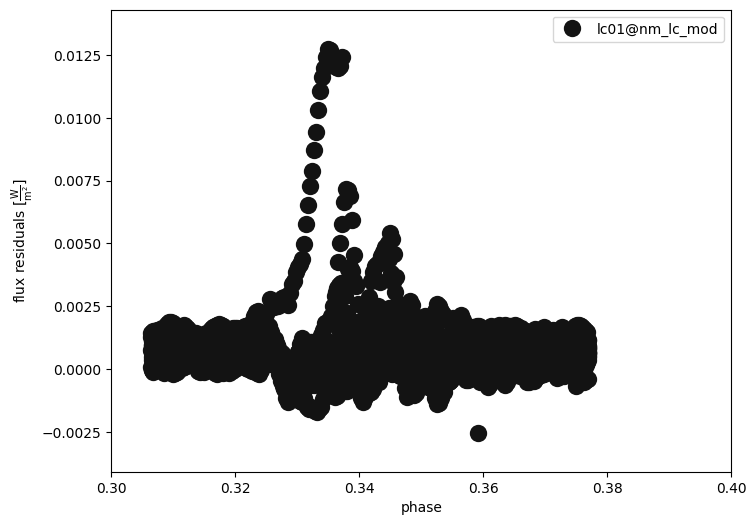

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [22]:
b.plot(kind='lc', model='nm_lc_mod', x='phases', y='residuals', show=True, xlim=(-0.05,0.05), legend=True, marker = 'o')
b.plot(kind='lc', model='nm_lc_mod', x='phases', y='residuals', show=True, xlim=(0.3,0.4), legend=True, marker = 'o')

Save the bundle before we proceed:

In [23]:
b.save('bundles/during_nm_phys.bundle')

'bundles/during_nm_phys.bundle'

Now let's include the radial velocity and fit both together:

In [24]:
b.enable_dataset('rv01')

<ParameterSet: 20 parameters | components: binary, secondary, primary>

We can now fit parameters that are relevant to both the rv and the light curve:

In [25]:
fit_params =['vgamma@system', 'q@binary', 'asini@binary','ecc@binary', 'per0@binary','teffratio@binary', 'requivratio', 'requivsumfrac@binary']
b.set_value('fit_parameters@nm_sol_phys', fit_params)

ValueError: 0 results found for twig: 'fit_parameters@nm_sol_phys', {'check_visible': True, 'check_default': True, 'check_advanced': False, 'check_single': False}

In [ ]:
b.run_solver(solver='nm_phys', solution='nm_sol_phys', overwrite=True)

In [ ]:
print(b.adopt_solution(solution='nm_sol_phys', trial_run=True))

In [ ]:
b.adopt_solution('nm_sol_phys')

In [ ]:
b.run_compute(compute='comp_phys', solution='nm_sol_phys', model='nm_phys_mod', sample_num=1,overwrite=True)


In [ ]:
b.plot(kind='lc', model='nm_phys_mod', x='phases', show=True, legend=True, marker = 'o',xlim=(-0.1,0.1))
b.plot(kind='lc', model='nm_phys_mod', x='phases', y='residuals', show=True, legend=True, marker = 'o',xlim=(-0.1,0.1))

In [ ]:
b.plot(kind='lc', model='after_nm_phys', x='phases', show=True, legend=True, marker = 'o',xlim=(0.3,0.4))
b.plot(kind='lc', model='after_nm_phys', x='phases', y='residuals', show=True, legend=True, marker = 'o',xlim=(0.3,0.4))

In [ ]:
fit_params = ['teffratio@binary', 'requivratio@secondary']#,'t0_supconj@binary']
b.set_value('fit_parameters@nm_phys', fit_params)

In [ ]:
b.run_solver(solver='nm_sol_phys', solution='nm_solution_phys_2', overwrite=True)

In [ ]:
print(b.adopt_solution(solution='nm_solution_phys_2', trial_run=True))

In [ ]:
b.run_compute(compute='comp_phys', solution='nm_solution_phys_2', model='after_nm_phys_2', sample_num=1,overwrite=True)

In [ ]:
b.plot(kind='lc', model='after_nm_phys_2', x='phases', show=True, legend=True, marker = 'o',xlim=(-0.05,0.05))
b.plot(kind='lc', model='after_nm_phys_2', x='phases', y='residuals', show=True, legend=True, marker = 'o',xlim=(-0.05,0.05))

In [ ]:
b.adopt_solution('nm_solution_phys_2')

In [ ]:
b.save('bundles/during_nm_phys.bundle')

In [ ]:
fit_params = ['teffratio@binary', 'requiv@primary','incl@binary','ecc@binary', 'per0@binary']#,'t0_supconj@binary']
b.set_value('fit_parameters@nm_sol_phys', fit_params)

In [ ]:
b.run_solver(solver='nm_sol_phys', solution='nm_solution_phys_2', overwrite=True)

In [ ]:
print(b.adopt_solution(solution='nm_solution_phys_2', trial_run=True))

In [ ]:
b.run_compute(compute='comp_phys', solution='nm_solution_phys_2', model='after_nm_phys_2', sample_num=1,overwrite=True)

In [ ]:
b.plot(kind='lc', model='after_nm_phys_2', x='phases', show=True, legend=True, marker = 'o')#,xlim=(-0.05,0.05))
b.plot(kind='lc', model='after_nm_phys_2', x='phases', y='residuals', show=True, legend=True, marker = 'o')#,xlim=(-0.05,0.05))

In [ ]:
b.adopt_solution(solution='nm_solution_phys_2')

In [ ]:
b.set_value('mask_enabled@lc01', False)

In [ ]:
b.enable_dataset('rv01')

In [ ]:
b.run_compute(compute='comp_phys', solution='nm_solution_phys_2', model='after_nm_phys_2', sample_num=1,overwrite=True)
b.plot(model='after_nm_phys_2', x='phases', show=True, legend=True, marker = 'o')

In [ ]:
b.plot(model=['after_nm_phys','literature','after_nm_phys_2'],x='phases', show=True, legend=True, marker = 'o')

In [ ]:
b.save('bundles/after_nm_phys.bundle')